<a href="https://colab.research.google.com/github/tfredrick112/CatDog/blob/master/CatvsDog_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat vs Dog classifier

We will improve the model used in part one by combatting overfitting with the help of **data augmentation** and **dropout regularization**.

### Downloading data and setting up the necessary directories

In [4]:
!nvidia-smi

Sun Dec 29 17:52:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2019-12-29 18:00:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  87.4MB/s    in 0.7s    

2019-12-29 18:00:46 (87.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

## Data Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40, # angle to rotate by (value can be between 0 and 180 degrees)
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

* rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* shear_range is for randomly applying shearing transformations.
* zoom_range is for randomly zooming inside pictures.
* horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


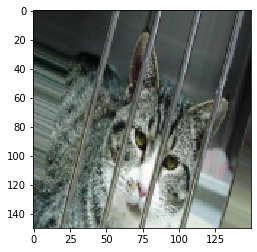

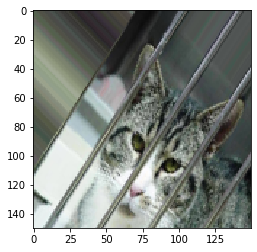

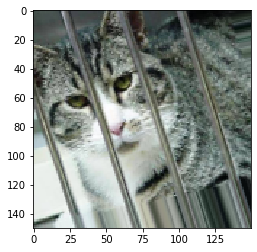

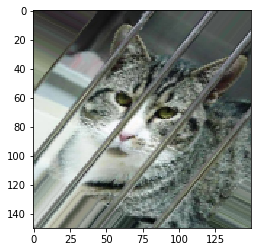

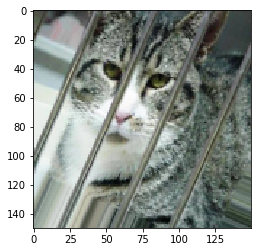

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img) # x.shape = (150, 150, 3)
x = x.reshape((1,) + x.shape) # final shape is (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

We now add Data Augmentation to the Preprocessing step

In [12]:
# add data augmentation to training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# no data augmnetation for validation set :)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Adding Dropout Regularization

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Input, Dropout
from tensorflow.keras import Model

In [0]:
X_input = Input(shape=(150, 150, 3))

X = Conv2D(16, (3, 3), kernel_initializer='glorot_uniform')(X_input)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)

X = Conv2D(32, (3, 3), kernel_initializer='glorot_uniform')(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Conv2D(64, (3, 3), kernel_initializer='glorot_uniform')(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Flatten()(X)

X = Dense(512, activation='relu')(X)

# adding a dropout layer with drop rate = 0.5, just before the output layer
X = Dropout(0.5)(X)

output = Dense(1, activation='sigmoid')(X)
# The output of the sigmoid will be the probability that the image has a label of 1.

model = Model(inputs = X_input, outputs = output)

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    verbose=2,
    validation_data = validation_generator,
    validation_steps=50
)

Epoch 1/30
Epoch 1/30
100/100 - 22s - loss: 0.7116 - acc: 0.5115 - val_loss: 0.6913 - val_acc: 0.5010
Epoch 2/30
Epoch 1/30
100/100 - 16s - loss: 0.6921 - acc: 0.5235 - val_loss: 0.6918 - val_acc: 0.5230
Epoch 3/30
Epoch 1/30
100/100 - 16s - loss: 0.6908 - acc: 0.5150 - val_loss: 0.6835 - val_acc: 0.5200
Epoch 4/30
Epoch 1/30
100/100 - 16s - loss: 0.6902 - acc: 0.5270 - val_loss: 0.6901 - val_acc: 0.5520
Epoch 5/30
Epoch 1/30
100/100 - 16s - loss: 0.6886 - acc: 0.5400 - val_loss: 0.6869 - val_acc: 0.5350
Epoch 6/30
Epoch 1/30
100/100 - 16s - loss: 0.6877 - acc: 0.5640 - val_loss: 0.6602 - val_acc: 0.5670
Epoch 7/30
Epoch 1/30
100/100 - 16s - loss: 0.6775 - acc: 0.5475 - val_loss: 0.6472 - val_acc: 0.6160
Epoch 8/30
Epoch 1/30
100/100 - 16s - loss: 0.6734 - acc: 0.5900 - val_loss: 0.6644 - val_acc: 0.6140
Epoch 9/30
Epoch 1/30
100/100 - 16s - loss: 0.6634 - acc: 0.5970 - val_loss: 0.6549 - val_acc: 0.5790
Epoch 10/30
Epoch 1/30
100/100 - 16s - loss: 0.6637 - acc: 0.5840 - val_loss: 0.65

Text(0.5, 1.0, 'Training and validation loss')

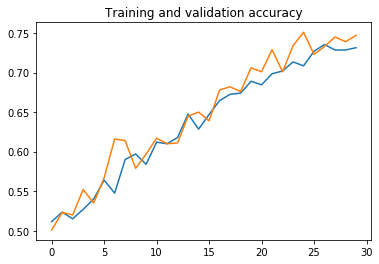

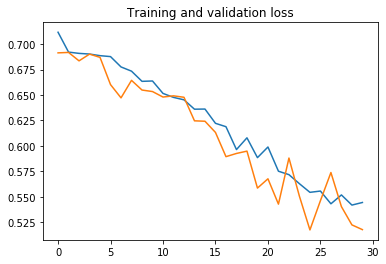

In [19]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')